# Use a model trained on 2020 data to predict for 2019 train

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from argparse import Namespace

In [17]:
from cassava.lmdb_dataset import *
from cassava.utils import *
from cassava.transforms import get_test_transforms

In [4]:
from cassava.models.model import LeafDoctorModel

In [5]:
from cassava.pipelines.train_model.nodes import score_model

In [6]:
parameters = context.catalog.load('parameters')

2020-12-22 23:58:00,391 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [7]:
train_lmdb = context.catalog.load('train_lmdb')

2020-12-22 23:58:00,437 - kedro.io.data_catalog - INFO - Loading data from `train_lmdb` (KedroImageLMDBDataSet)...


## Make sure the model was only trained on 2020 data

In [8]:
cv_results = context.catalog.load('cv_results')

2020-12-22 23:58:00,491 - kedro.io.data_catalog - INFO - Loading data from `cv_results` (PickleDataSet)...


In [9]:
model_checkpoint = '../'+cv_results['fold_0']['model_path']

In [10]:
hparams = Namespace(**parameters['classifier'])
model = LeafDoctorModel(hparams)
model.load_state_dict(torch.load(model_checkpoint))

<All keys matched successfully>

In [11]:
train_2019_indices = np.array(range(len(train_lmdb)))[train_lmdb.sources == 'train_2019']

In [20]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [22]:
img, label = train_lmdb[train_2019_indices[0]]

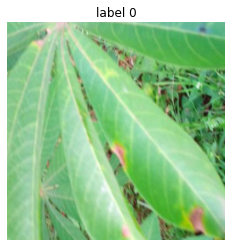

In [27]:
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}')

In [12]:
parameters['classifier']['batch_size'] = 10

In [30]:
score_model(model, train_lmdb, train_2019_indices, parameters)[0]

2020-12-23 00:03:57,607 - root - INFO - Scoring model



2020-12-23 00:04:37,814 - root - INFO - Validation scores:
{'accuracy': 0.6396597123759368, 'f1_score': 0.6098117197176313}


{'accuracy': 0.6396597123759368, 'f1_score': 0.6098117197176313}